In [1]:
# load the needed packages
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import datetime
import numpy as np

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from scipy.spatial import distance

In [ ]:
# read new dataset from AAG
#df = pd.read_parquet('cleaned_data.parquet')

# Only keep rows in 2023?
#df = df[["OrderNumber", "OrderDate", "CustomerID", "NetRevenue", "Quantity", "Season", "City", "SalesChannel"]]
#df = df[df['OrderDate'].dt.year == 2023]
#df.info()

In [ ]:
#### either run the customer prediction file first or load the needed datasets created before ####

# idea: take cluster assignments from customer clustering
# within each cluster, fit model to NetRevenue data (2022,2023)
# predict future NetRevenue per CustomerID (2024)


# get customer - cluster assignment when running the clustering file 
# ...
# clustered_customers_df = top25_scaled[["CustomerID", "cluster"]]
# clustered_customers_df.to_csv('clusterAssignments.csv', index = False)

# get customer - cluster assignment from pre-saved file
clustered_customers_df = pd.read_csv('clusterAssignments.csv', sep = ",") #this file is created after running the clustering
clustered_customers_df.CustomerID = clustered_customers_df.CustomerID.astype(str)

c_subsets = {}
for num in clustered_customers_df['cluster'].unique():
    c_subsets[num] = clustered_customers_df[clustered_customers_df['cluster'] == num]

# subset per cluster, use smallest cluster for first LSTM approaches
print(c_subsets[2].info())

# get customer - order data when running the clustering file 
# ...
#orders_subsets = orders_subsets.fillna(value = 1)
# orders_subsets.head(20)
#orders_subsets = orders_top25[orders_top25['CustomerID'].isin(c_subsets[2]['CustomerID'])]
# orders_subsets.to_csv("cluster3Orders.csv", index = False)

# get customer - order data from pre-saved file
orders_subsets = pd.read_csv("cluster3Orders.csv")
orders_subsets['OrderDate'] = pd.to_datetime(orders_subsets['OrderDate'], format='%Y-%m-%d')
print(orders_subsets.info())


# tbd
# add rfm features per customer ID on weekly basis?? even necessary if predictions on entire cluster?? TBD
# result: if we aggregate on cluster level instead of customer level 
# then we cannot use any of the previously planned features?!

   OrderDate    NetRevenue  Quantity
0 2021-12-27   3061.350785     738.0
1 2022-01-03  20784.907068    6466.0
2 2022-01-10  12727.215969    2967.0
3 2022-01-17  14527.650524    2575.0
4 2022-01-24  11662.307592    3401.0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 131 entries, 0 to 130
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   OrderDate   131 non-null    datetime64[ns]
 1   NetRevenue  131 non-null    float64       
 2   Quantity    131 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 4.1 KB
None


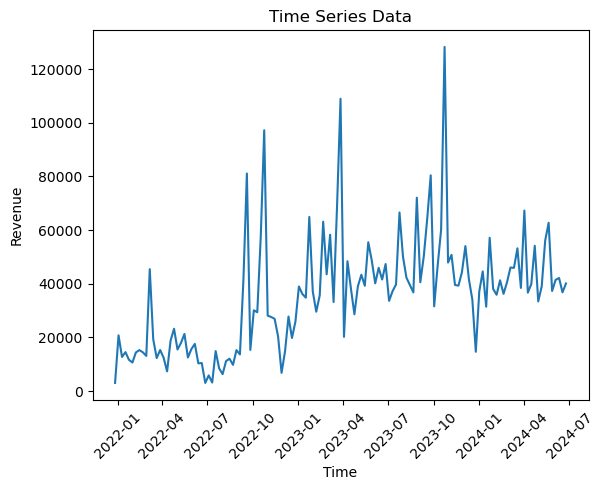

In [3]:
# prepare the time series data
customlevelpred = orders_subsets.sort_values(by="OrderDate")
customlevelpred = customlevelpred.groupby('OrderDate')[['NetRevenue', 'Quantity']].sum().reset_index()
# aggregate on weekly basis
customlevelpred = customlevelpred.groupby([pd.Grouper(key='OrderDate', freq='W-MON', label='left')])[['NetRevenue', 'Quantity']].sum().reset_index().sort_values('OrderDate')

# set date as indexing value for time series analyses such as ARIMA
#customlevelpred.set_index('OrderDate', inplace=True)

print(customlevelpred.head())
print(customlevelpred.info())

# plot the time series
plt.plot(customlevelpred["OrderDate"], customlevelpred["NetRevenue"])
plt.xlabel('Time')
plt.ylabel('Revenue')
plt.xticks(rotation = 45)
plt.title('Time Series Data')
plt.show()

ADF Statistic: -2.3548882842341907
p-value: 0.1548755831197295
	1%: -3.483
	5%: -2.885
	10%: -2.579


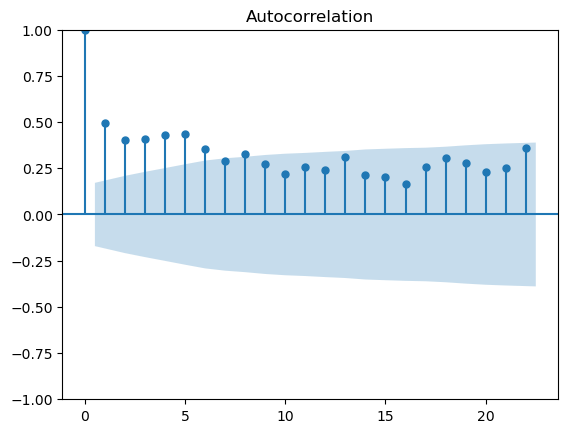

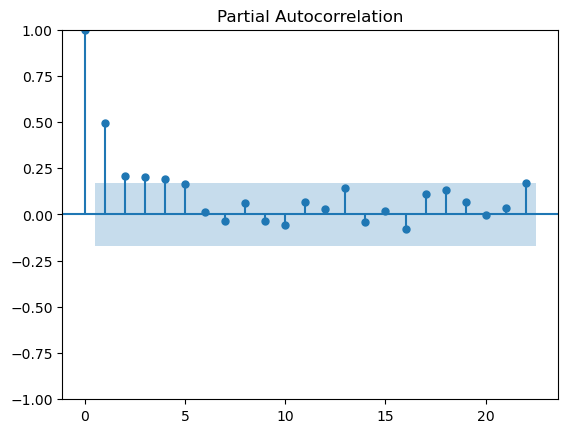

In [4]:
# USE THIS ONE for fitting on different functions
# TBD handle stationarity, trend, seasonality



# following code based on https://www.timescale.com/blog/how-to-work-with-time-series-in-python/
    
# test for stationarity
from statsmodels.tsa.stattools import adfuller
# Assuming 'data' is the time series data
result = adfuller(customlevelpred["NetRevenue"])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
# p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary
# TBD cluster 3 data: revenue is not stationary, rescale for better predictions

# test for autocorrelation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Assuming 'data' is the time series data
plot_acf(customlevelpred["NetRevenue"])
plot_pacf(customlevelpred["NetRevenue"])
plt.show()
# ACF are within 95% confidence interval = data doesn’t have any autocorrelation
# ACF outside of interval = autocorrelation
# TBD cluster 3 data: potential autocorrelation between lags 1 to 5, consider either before or during training



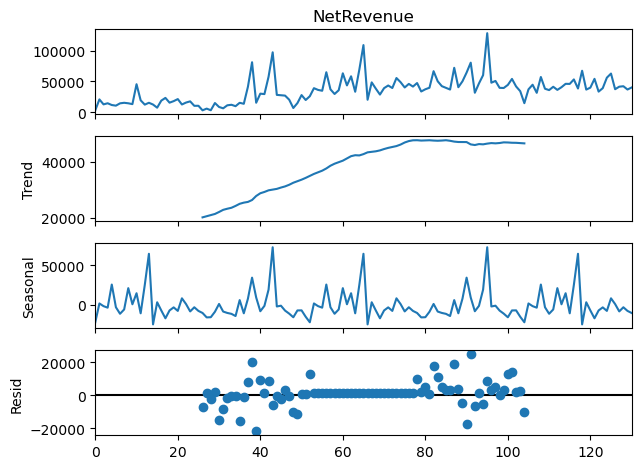

In [5]:
# TBD handle trend and seasonality
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_result = seasonal_decompose(customlevelpred["NetRevenue"], period = 52).plot()
#decompose_result.plot()

<Axes: title={'center': 'SARIMAX'}>

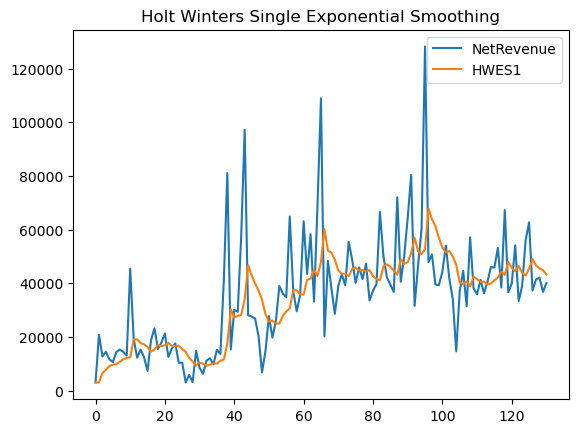

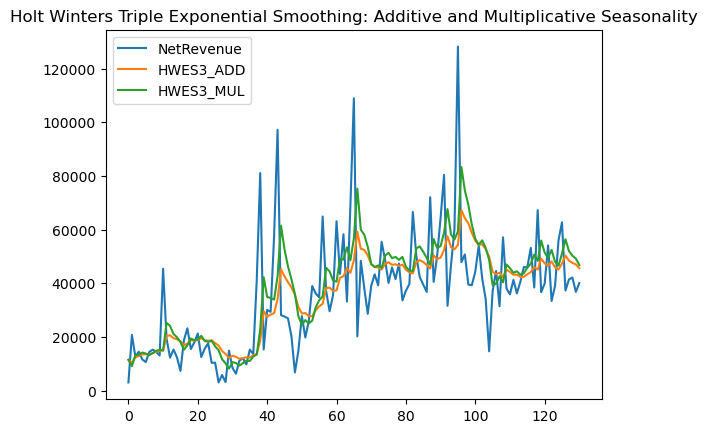

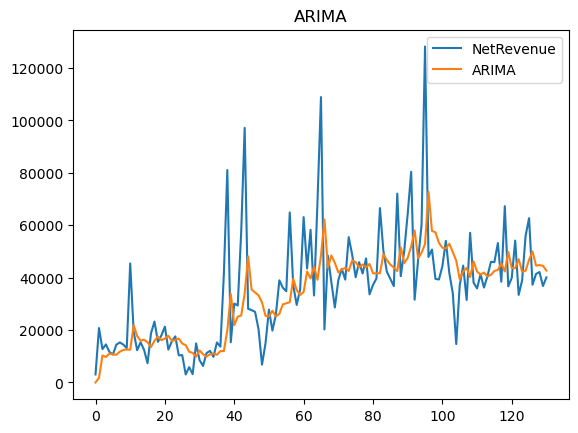

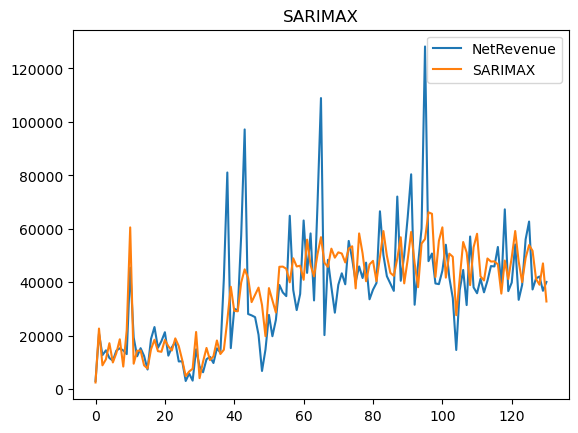

In [5]:
# customer level traditional prediction approaches

#import warnings
#warnings.filterwarnings("ignore")

# TBD further look into traditional time series analysis methods in addition to ML approaches below
# following code based on https://medium.com/analytics-vidhya/python-code-on-holt-winters-forecasting-3843808a9873

# single exponential smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
customlevelpred["HWES1"] = SimpleExpSmoothing(customlevelpred["NetRevenue"]).fit().fittedvalues
customlevelpred[["NetRevenue","HWES1"]].plot(title="Holt Winters Single Exponential Smoothing")


# double and triple exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
customlevelpred["HWES3_ADD"] = ExponentialSmoothing(customlevelpred["NetRevenue"],trend="add").fit().fittedvalues
customlevelpred["HWES3_MUL"] = ExponentialSmoothing(customlevelpred["NetRevenue"],trend="mul").fit().fittedvalues
customlevelpred[["NetRevenue","HWES3_ADD", "HWES3_MUL"]].plot(title="Holt Winters Triple Exponential Smoothing: Additive and Multiplicative Seasonality")


# following code based on https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/
# ARIMA
from statsmodels.tsa.arima.model import ARIMA
# fit model
model = ARIMA(customlevelpred["NetRevenue"], order=(1, 1, 1))
customlevelpred["ARIMA"] = model_fit = model.fit().fittedvalues
customlevelpred[["NetRevenue","ARIMA"]].plot(title="ARIMA")
# make prediction tbd
#yhat = model_fit.predict(len(itemlevelpred), len(itemlevelpred), typ='levels')
#print(yhat)
 
# SARIMAX example
# plots: best fitting
# TBD look into further optimization and potential predictions using SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAX

data1=customlevelpred["NetRevenue"]
#data1.head()
data2 = customlevelpred["Quantity"]
model = SARIMAX(data1, exog=data2,  enforce_stationarity=True,  order=(5, 2, 5))
customlevelpred["SARIMAX"] = model.fit().fittedvalues
customlevelpred[["NetRevenue","SARIMAX"]].plot(title="SARIMAX")

In [ ]:
# not needed anymore

# tbd make prediction SARIMAX
yhat = model_fit.get_prediction(start = "2024-01-01", end = "2024-12-01")# tbd exog variable??
print(yhat)



# tried random forest for time series analysis 
# but realized that this might not be suitable in our context because it does not consider the time aspect

# following code based on https://swngui.medium.com/python-tutorial-using-random-forest-for-sales-forecasting-bda61d79318e

from sklearn.ensemble import RandomForestRegressor

customlevelpred1 = customlevelpred[["OrderDate", "NetRevenue", "Quantity"]]
train_data, test_data = customlevelpred1.loc[customlevelpred1["OrderDate"] < "2024-01-01"], customlevelpred1.loc[customlevelpred1["OrderDate"] > "2024-01-01"]

train_data.info()
test_data.info()

# Initialize the model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
rf.fit(train_data.drop(['OrderDate','NetRevenue'], axis=1), train_data['NetRevenue'])

# Predict the sales for the testing data
predictions = rf.predict(test_data.drop(['OrderDate','NetRevenue'], axis=1))

# Calculate the root mean squared error (RMSE)
rmse = ((predictions - test_data['NetRevenue']) ** 2).mean() ** 0.5
print('Root Mean Squared Error: {:.2f}'.format(rmse))

# Plot the actual and predicted sales
plt.scatter(test_data['NetRevenue'], predictions)
plt.xlabel('Actual Revenue')
plt.ylabel('Predicted Revenue')
plt.show()

In [6]:
# clean data for lstm if Arima models were run before
customlevelpred = customlevelpred.drop(["HWES1", "HWES3_ADD", "HWES3_MUL", "ARIMA", "SARIMAX"], axis = 1)
customlevelpred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131 entries, 0 to 130
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   OrderDate   131 non-null    datetime64[ns]
 1   NetRevenue  131 non-null    float64       
 2   Quantity    131 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 4.1 KB


   OrderDate    NetRevenue
0 2021-12-27   3061.350785
1 2022-01-03  20784.907068
2 2022-01-10  12727.215969
3 2022-01-17  14527.650524
4 2022-01-24  11662.307592
<class 'pandas.core.frame.DataFrame'>
Int64Index: 131 entries, 0 to 130
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   OrderDate   131 non-null    datetime64[ns]
 1   NetRevenue  131 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.1 KB
None


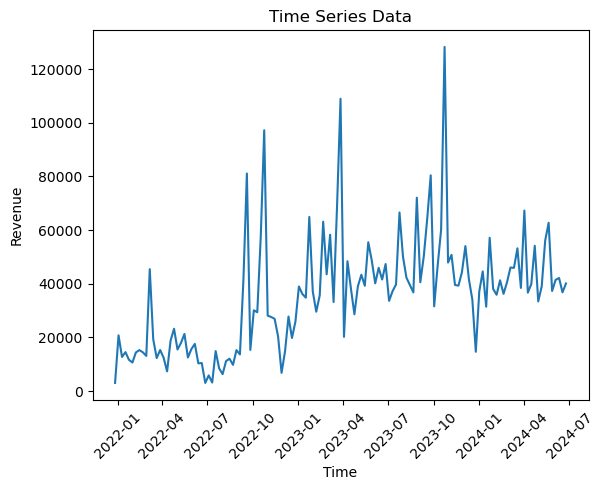

104 27


In [4]:
# LSTM for time series forecasting not done yet
# TBD fine tuning, optimal parameter
# grid search DONE
# TBD find ideal loss function, layer architecture, accuracy measures for time series in our context
# TBD use additional input features for more information, ideas: orderCount, Quantities, different ArticleIDs aggregated on cluster level


# code (following cells for LSTM) based on https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
# load packages
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# get input data and inspect to now basis
lstmdatainput = customlevelpred.drop("Quantity", axis = 1)
print(lstmdatainput.head())
print(lstmdatainput.info())

# plot the time series that is considered as input array
plt.plot(lstmdatainput["OrderDate"], lstmdatainput['NetRevenue'])
plt.xlabel('Time')
plt.ylabel('Revenue')
plt.xticks(rotation = 45)
plt.title('Time Series Data')
plt.show()


# random seed for reproducibility
tf.random.set_seed(5)

# transform integer into float for better handling in NN
dataframe = lstmdatainput["NetRevenue"]
dataset = dataframe.values
dataset = dataset.astype('float32')

#print(dataset)

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1))

#print(dataset)

# create trainign and testing split
# TBD adapt to be split on 2022/2023 - 2024 (104 weeks training, 27 (of 2024) weeks testing)
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

In [5]:
# function for creating the data input in LSTM format

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [18]:
# has to be rerun before every model training otherwise input format is messed up

# TBD find best lag (cf. autocorrelation displayed in lags 1 to 5)
# lag 2 already got better results than lag 1, find optimal one
look_back = 2 
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

### grid search

In [33]:
# grid search to test combinations of parameters to find best settings
# takes a while to run with as many paramters to check, should not be necessary to rerun again

# reference https://blog.gopenai.com/how-to-perform-grid-search-hyperparameter-tuning-for-lstm-9bed04932d95

from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

# Create the LSTM for grid search
def create_lstm_model(neurons=36, second_layer=12, loss='mean_absolute_error', activation='relu', optimizer='Adam', batch_size=12):
    model = Sequential()
    model.add(LSTM(units=neurons, activation=activation, input_shape=(1, look_back)))
    
    #if second_layer > 0: 
    #    model.add(LSTM(units=second_layer, return_sequences=False))
    
    model.add(Dense(1))
    model.compile(loss=loss, optimizer=optimizer, metrics=['mse'])
    
    return model

# Wrap the custom wrapper function for use with scikit-learn
lstm_regressor = KerasRegressor(build_fn=create_lstm_model, epochs=50, batch_size=6, verbose=0)

# all parameter combinations to test
param_grid = {
    'optimizer': ['SGD', 'Adam'],
    'loss': ['mean_squared_error', 'mean_absolute_error', 'root_mean_squared_error', 'huber'],
    'batch_size': [1, 4, 6], # 12
    'epochs': [100, 250],
    'neurons': [12, 24],
    #'second_layer':[0, 12],  # 0 means no second LSTM layer
    'activation': ['relu', 'tanh'] #['relu', 'tanh', 'sigmoid', 'linear']
}

# run the grid search algorithm on the LSTM
grid_search = GridSearchCV(estimator=lstm_regressor, param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=3)
grid_search_result = grid_search.fit(trainX, trainY)


In [59]:
# show the 10 best parameter sets
results_df = pd.DataFrame(grid_search_result.cv_results_)
top_params = results_df.nlargest(10, 'mean_test_score')[['params', 'mean_test_score', 'mean_fit_time']]
pd.options.display.max_colwidth = 110
print(top_params)

#print(top_params.params)
#print(top_params.loc[1,"params"])

print("")
print("Best: %f using %s" % (grid_search_result.best_score_, grid_search_result.best_params_))
means = grid_search_result.cv_results_['mean_test_score']
stds = grid_search_result.cv_results_['std_test_score']
params = grid_search_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
#Best: -0.148562 using {'activation': 'relu', 'batch_size': 4, 'epochs': 250, 'loss': 'huber', 'neurons': 24, 'optimizer': 'Adam'}

                                                                                                            params  \
63     {'activation': 'relu', 'batch_size': 4, 'epochs': 250, 'loss': 'huber', 'neurons': 24, 'optimizer': 'Adam'}   
15     {'activation': 'relu', 'batch_size': 1, 'epochs': 100, 'loss': 'huber', 'neurons': 24, 'optimizer': 'Adam'}   
127    {'activation': 'tanh', 'batch_size': 1, 'epochs': 250, 'loss': 'huber', 'neurons': 24, 'optimizer': 'Adam'}   
29     {'activation': 'relu', 'batch_size': 1, 'epochs': 250, 'loss': 'huber', 'neurons': 12, 'optimizer': 'Adam'}   
51   {'activation': 'relu', 'batch_size': 4, 'epochs': 250, 'loss': 'mean_squared_error', 'neurons': 24, 'optim...   
31     {'activation': 'relu', 'batch_size': 1, 'epochs': 250, 'loss': 'huber', 'neurons': 24, 'optimizer': 'Adam'}   
7    {'activation': 'relu', 'batch_size': 1, 'epochs': 100, 'loss': 'mean_absolute_error', 'neurons': 24, 'opti...   
3    {'activation': 'relu', 'batch_size': 1, 'epochs': 1

### train model

in the following, different parameter settings are tested and evaluated on their prediction quality

basis: grid search proposed best parameter settings + literature search on LSTM parameter fine tuning

In [11]:
# option 1 from reference above

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
# TBD add second dense layer with more units? or pooling layer??
model.add(Dense(1))
# TBD choose best loss function 
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae', 'mape'])
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
101/101 - 3s - loss: 0.0466 - mse: 0.0466 - mae: 0.1519 - mape: 901367.5000 - 3s/epoch - 28ms/step
Epoch 2/100
101/101 - 0s - loss: 0.0282 - mse: 0.0282 - mae: 0.1183 - mape: 1636167.0000 - 235ms/epoch - 2ms/step
Epoch 3/100
101/101 - 0s - loss: 0.0256 - mse: 0.0256 - mae: 0.1162 - mape: 1792187.6250 - 235ms/epoch - 2ms/step
Epoch 4/100
101/101 - 0s - loss: 0.0250 - mse: 0.0250 - mae: 0.1132 - mape: 1683395.6250 - 230ms/epoch - 2ms/step
Epoch 5/100
101/101 - 0s - loss: 0.0246 - mse: 0.0246 - mae: 0.1140 - mape: 1775626.8750 - 274ms/epoch - 3ms/step
Epoch 6/100
101/101 - 0s - loss: 0.0244 - mse: 0.0244 - mae: 0.1126 - mape: 1751704.3750 - 236ms/epoch - 2ms/step
Epoch 7/100
101/101 - 0s - loss: 0.0242 - mse: 0.0242 - mae: 0.1152 - mape: 1757462.5000 - 234ms/epoch - 2ms/step
Epoch 8/100
101/101 - 0s - loss: 0.0241 - mse: 0.0241 - mae: 0.1117 - mape: 1590660.3750 - 250ms/epoch - 2ms/step
Epoch 9/100
101/101 - 0s - loss: 0.0240 - mse: 0.0240 - mae: 0.1094 - mape: 1549255.5000 - 

Epoch 73/100
101/101 - 0s - loss: 0.0202 - mse: 0.0202 - mae: 0.0950 - mape: 1017164.6250 - 299ms/epoch - 3ms/step
Epoch 74/100
101/101 - 0s - loss: 0.0202 - mse: 0.0202 - mae: 0.0970 - mape: 1064999.7500 - 336ms/epoch - 3ms/step
Epoch 75/100
101/101 - 0s - loss: 0.0202 - mse: 0.0202 - mae: 0.0988 - mape: 1087301.3750 - 334ms/epoch - 3ms/step
Epoch 76/100
101/101 - 0s - loss: 0.0200 - mse: 0.0200 - mae: 0.0950 - mape: 977304.9375 - 340ms/epoch - 3ms/step
Epoch 77/100
101/101 - 0s - loss: 0.0200 - mse: 0.0200 - mae: 0.0974 - mape: 1076519.5000 - 329ms/epoch - 3ms/step
Epoch 78/100
101/101 - 0s - loss: 0.0200 - mse: 0.0200 - mae: 0.0973 - mape: 959856.2500 - 335ms/epoch - 3ms/step
Epoch 79/100
101/101 - 0s - loss: 0.0201 - mse: 0.0201 - mae: 0.0938 - mape: 949059.2500 - 312ms/epoch - 3ms/step
Epoch 80/100
101/101 - 0s - loss: 0.0199 - mse: 0.0199 - mae: 0.0946 - mape: 924379.7500 - 323ms/epoch - 3ms/step
Epoch 81/100
101/101 - 0s - loss: 0.0199 - mse: 0.0199 - mae: 0.0943 - mape: 945897.

In [57]:
# option 1.2 from reference but different loss function 

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
# check https://medium.com/@tpyrt1069098/there-are-14-loss-functions-for-regression-tasks-you-know-several-of-them-5ecd5e77a599
model.compile(loss='huber', optimizer='adam', metrics=['mse', 'mae', 'mape'])
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
101/101 - 3s - loss: 0.0277 - mse: 0.0553 - mae: 0.1695 - mape: 855501.9375 - 3s/epoch - 29ms/step
Epoch 2/100
101/101 - 0s - loss: 0.0157 - mse: 0.0313 - mae: 0.1244 - mape: 1639430.3750 - 230ms/epoch - 2ms/step
Epoch 3/100
101/101 - 0s - loss: 0.0135 - mse: 0.0271 - mae: 0.1188 - mape: 1854414.0000 - 236ms/epoch - 2ms/step
Epoch 4/100
101/101 - 0s - loss: 0.0131 - mse: 0.0261 - mae: 0.1159 - mape: 1784666.6250 - 233ms/epoch - 2ms/step
Epoch 5/100
101/101 - 0s - loss: 0.0128 - mse: 0.0256 - mae: 0.1164 - mape: 1860849.8750 - 235ms/epoch - 2ms/step
Epoch 6/100
101/101 - 0s - loss: 0.0127 - mse: 0.0254 - mae: 0.1151 - mape: 1854844.5000 - 233ms/epoch - 2ms/step
Epoch 7/100
101/101 - 0s - loss: 0.0126 - mse: 0.0252 - mae: 0.1171 - mape: 1865206.6250 - 233ms/epoch - 2ms/step
Epoch 8/100
101/101 - 0s - loss: 0.0125 - mse: 0.0251 - mae: 0.1146 - mape: 1725054.8750 - 243ms/epoch - 2ms/step
Epoch 9/100
101/101 - 0s - loss: 0.0124 - mse: 0.0249 - mae: 0.1127 - mape: 1672204.5000 - 

Epoch 73/100
101/101 - 0s - loss: 0.0104 - mse: 0.0208 - mae: 0.0965 - mape: 1101016.0000 - 334ms/epoch - 3ms/step
Epoch 74/100
101/101 - 0s - loss: 0.0104 - mse: 0.0208 - mae: 0.0983 - mape: 1144332.2500 - 319ms/epoch - 3ms/step
Epoch 75/100
101/101 - 0s - loss: 0.0104 - mse: 0.0209 - mae: 0.1000 - mape: 1178558.6250 - 315ms/epoch - 3ms/step
Epoch 76/100
101/101 - 0s - loss: 0.0103 - mse: 0.0207 - mae: 0.0969 - mape: 1085059.5000 - 303ms/epoch - 3ms/step
Epoch 77/100
101/101 - 0s - loss: 0.0103 - mse: 0.0207 - mae: 0.0986 - mape: 1156690.0000 - 298ms/epoch - 3ms/step
Epoch 78/100
101/101 - 0s - loss: 0.0103 - mse: 0.0206 - mae: 0.0986 - mape: 1065429.5000 - 313ms/epoch - 3ms/step
Epoch 79/100
101/101 - 0s - loss: 0.0103 - mse: 0.0206 - mae: 0.0954 - mape: 1054621.2500 - 331ms/epoch - 3ms/step
Epoch 80/100
101/101 - 0s - loss: 0.0102 - mse: 0.0205 - mae: 0.0964 - mape: 1024292.7500 - 343ms/epoch - 3ms/step
Epoch 81/100
101/101 - 0s - loss: 0.0102 - mse: 0.0204 - mae: 0.0959 - mape: 104

In [19]:
# option 1.3 best parameters as proposed from grid search

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(24, activation='relu', input_shape=(1, look_back)))
# TBD add second dense layer with more units?
model.add(Dense(1))
model.compile(loss='huber', optimizer='adam', metrics=['mse', 'mae', 'mape'])
model.fit(trainX, trainY, epochs=250, batch_size=4, verbose=2)

Epoch 1/250
26/26 - 2s - loss: 0.0417 - mse: 0.0834 - mae: 0.2265 - mape: 293903.8438 - 2s/epoch - 76ms/step
Epoch 2/250
26/26 - 0s - loss: 0.0299 - mse: 0.0599 - mae: 0.1763 - mape: 849718.3125 - 70ms/epoch - 3ms/step
Epoch 3/250
26/26 - 0s - loss: 0.0211 - mse: 0.0422 - mae: 0.1428 - mape: 1279864.7500 - 69ms/epoch - 3ms/step
Epoch 4/250
26/26 - 0s - loss: 0.0159 - mse: 0.0318 - mae: 0.1254 - mape: 1463560.2500 - 66ms/epoch - 3ms/step
Epoch 5/250
26/26 - 0s - loss: 0.0139 - mse: 0.0278 - mae: 0.1193 - mape: 1639649.3750 - 62ms/epoch - 2ms/step
Epoch 6/250
26/26 - 0s - loss: 0.0132 - mse: 0.0265 - mae: 0.1165 - mape: 1808729.8750 - 62ms/epoch - 2ms/step
Epoch 7/250
26/26 - 0s - loss: 0.0133 - mse: 0.0266 - mae: 0.1195 - mape: 1903450.6250 - 68ms/epoch - 3ms/step
Epoch 8/250
26/26 - 0s - loss: 0.0131 - mse: 0.0262 - mae: 0.1178 - mape: 1927384.7500 - 66ms/epoch - 3ms/step
Epoch 9/250
26/26 - 0s - loss: 0.0130 - mse: 0.0260 - mae: 0.1166 - mape: 1852337.1250 - 69ms/epoch - 3ms/step
Epoc

Epoch 75/250
26/26 - 0s - loss: 0.0088 - mse: 0.0177 - mae: 0.0905 - mape: 831265.5000 - 81ms/epoch - 3ms/step
Epoch 76/250
26/26 - 0s - loss: 0.0087 - mse: 0.0175 - mae: 0.0881 - mape: 733751.6250 - 81ms/epoch - 3ms/step
Epoch 77/250
26/26 - 0s - loss: 0.0088 - mse: 0.0176 - mae: 0.0917 - mape: 843466.3750 - 81ms/epoch - 3ms/step
Epoch 78/250
26/26 - 0s - loss: 0.0087 - mse: 0.0174 - mae: 0.0913 - mape: 807167.4375 - 85ms/epoch - 3ms/step
Epoch 79/250
26/26 - 0s - loss: 0.0089 - mse: 0.0178 - mae: 0.0878 - mape: 742273.5000 - 81ms/epoch - 3ms/step
Epoch 80/250
26/26 - 0s - loss: 0.0087 - mse: 0.0174 - mae: 0.0885 - mape: 705758.5625 - 89ms/epoch - 3ms/step
Epoch 81/250
26/26 - 0s - loss: 0.0087 - mse: 0.0173 - mae: 0.0886 - mape: 723276.1875 - 91ms/epoch - 4ms/step
Epoch 82/250
26/26 - 0s - loss: 0.0087 - mse: 0.0173 - mae: 0.0904 - mape: 807428.8125 - 89ms/epoch - 3ms/step
Epoch 83/250
26/26 - 0s - loss: 0.0087 - mse: 0.0174 - mae: 0.0902 - mape: 758872.1875 - 91ms/epoch - 3ms/step
E

Epoch 149/250
26/26 - 0s - loss: 0.0085 - mse: 0.0170 - mae: 0.0896 - mape: 627695.1875 - 97ms/epoch - 4ms/step
Epoch 150/250
26/26 - 0s - loss: 0.0085 - mse: 0.0170 - mae: 0.0919 - mape: 747949.3750 - 92ms/epoch - 4ms/step
Epoch 151/250
26/26 - 0s - loss: 0.0084 - mse: 0.0169 - mae: 0.0903 - mape: 661427.8125 - 98ms/epoch - 4ms/step
Epoch 152/250
26/26 - 0s - loss: 0.0085 - mse: 0.0170 - mae: 0.0887 - mape: 650954.3750 - 90ms/epoch - 3ms/step
Epoch 153/250
26/26 - 0s - loss: 0.0085 - mse: 0.0170 - mae: 0.0902 - mape: 733082.0625 - 92ms/epoch - 4ms/step
Epoch 154/250
26/26 - 0s - loss: 0.0084 - mse: 0.0169 - mae: 0.0905 - mape: 731362.4375 - 81ms/epoch - 3ms/step
Epoch 155/250
26/26 - 0s - loss: 0.0084 - mse: 0.0168 - mae: 0.0901 - mape: 686126.6250 - 92ms/epoch - 4ms/step
Epoch 156/250
26/26 - 0s - loss: 0.0085 - mse: 0.0169 - mae: 0.0920 - mape: 731940.9375 - 92ms/epoch - 4ms/step
Epoch 157/250
26/26 - 0s - loss: 0.0084 - mse: 0.0169 - mae: 0.0901 - mape: 695652.6250 - 92ms/epoch - 4

26/26 - 0s - loss: 0.0084 - mse: 0.0167 - mae: 0.0896 - mape: 647631.1875 - 90ms/epoch - 3ms/step
Epoch 223/250
26/26 - 0s - loss: 0.0084 - mse: 0.0169 - mae: 0.0918 - mape: 718197.2500 - 93ms/epoch - 4ms/step
Epoch 224/250
26/26 - 0s - loss: 0.0084 - mse: 0.0169 - mae: 0.0915 - mape: 659922.9375 - 96ms/epoch - 4ms/step
Epoch 225/250
26/26 - 0s - loss: 0.0084 - mse: 0.0168 - mae: 0.0915 - mape: 702098.3750 - 97ms/epoch - 4ms/step
Epoch 226/250
26/26 - 0s - loss: 0.0084 - mse: 0.0168 - mae: 0.0889 - mape: 619101.3750 - 101ms/epoch - 4ms/step
Epoch 227/250
26/26 - 0s - loss: 0.0084 - mse: 0.0168 - mae: 0.0916 - mape: 771533.2500 - 103ms/epoch - 4ms/step
Epoch 228/250
26/26 - 0s - loss: 0.0083 - mse: 0.0167 - mae: 0.0909 - mape: 718154.9375 - 105ms/epoch - 4ms/step
Epoch 229/250
26/26 - 0s - loss: 0.0083 - mse: 0.0167 - mae: 0.0907 - mape: 693839.4375 - 101ms/epoch - 4ms/step
Epoch 230/250
26/26 - 0s - loss: 0.0084 - mse: 0.0168 - mae: 0.0910 - mape: 741725.0625 - 103ms/epoch - 4ms/step
E

In [15]:
# option 2 include dropouts for overfitting - better
from tensorflow.keras.layers import Dropout

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(1, look_back), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae', 'mape'])
model.fit(trainX, trainY, epochs=250, batch_size=4, verbose=2)

Epoch 1/250
26/26 - 3s - loss: 0.0814 - mse: 0.0814 - mae: 0.2218 - mape: 388613.3750 - 3s/epoch - 127ms/step
Epoch 2/250
26/26 - 0s - loss: 0.0518 - mse: 0.0518 - mae: 0.1615 - mape: 1394781.1250 - 122ms/epoch - 5ms/step
Epoch 3/250
26/26 - 0s - loss: 0.0312 - mse: 0.0312 - mae: 0.1311 - mape: 2115103.2500 - 122ms/epoch - 5ms/step
Epoch 4/250
26/26 - 0s - loss: 0.0291 - mse: 0.0291 - mae: 0.1278 - mape: 2080402.2500 - 117ms/epoch - 4ms/step
Epoch 5/250
26/26 - 0s - loss: 0.0290 - mse: 0.0290 - mae: 0.1266 - mape: 1845015.2500 - 97ms/epoch - 4ms/step
Epoch 6/250
26/26 - 0s - loss: 0.0274 - mse: 0.0274 - mae: 0.1205 - mape: 1774734.8750 - 102ms/epoch - 4ms/step
Epoch 7/250
26/26 - 0s - loss: 0.0269 - mse: 0.0269 - mae: 0.1236 - mape: 1747161.6250 - 101ms/epoch - 4ms/step
Epoch 8/250
26/26 - 0s - loss: 0.0256 - mse: 0.0256 - mae: 0.1185 - mape: 1868347.6250 - 101ms/epoch - 4ms/step
Epoch 9/250
26/26 - 0s - loss: 0.0264 - mse: 0.0264 - mae: 0.1169 - mape: 1808226.0000 - 99ms/epoch - 4ms/s

Epoch 75/250
26/26 - 0s - loss: 0.0180 - mse: 0.0180 - mae: 0.0979 - mape: 959264.3125 - 162ms/epoch - 6ms/step
Epoch 76/250
26/26 - 0s - loss: 0.0191 - mse: 0.0191 - mae: 0.0926 - mape: 863796.3750 - 133ms/epoch - 5ms/step
Epoch 77/250
26/26 - 0s - loss: 0.0188 - mse: 0.0188 - mae: 0.0957 - mape: 624039.3125 - 134ms/epoch - 5ms/step
Epoch 78/250
26/26 - 0s - loss: 0.0168 - mse: 0.0168 - mae: 0.0929 - mape: 569471.7500 - 132ms/epoch - 5ms/step
Epoch 79/250
26/26 - 0s - loss: 0.0186 - mse: 0.0186 - mae: 0.0890 - mape: 648713.8125 - 125ms/epoch - 5ms/step
Epoch 80/250
26/26 - 0s - loss: 0.0181 - mse: 0.0181 - mae: 0.0957 - mape: 604919.8125 - 132ms/epoch - 5ms/step
Epoch 81/250
26/26 - 0s - loss: 0.0184 - mse: 0.0184 - mae: 0.0910 - mape: 544090.1875 - 132ms/epoch - 5ms/step
Epoch 82/250
26/26 - 0s - loss: 0.0184 - mse: 0.0184 - mae: 0.0942 - mape: 1088133.2500 - 126ms/epoch - 5ms/step
Epoch 83/250
26/26 - 0s - loss: 0.0199 - mse: 0.0199 - mae: 0.0944 - mape: 680313.8125 - 131ms/epoch - 

Epoch 148/250
26/26 - 0s - loss: 0.0160 - mse: 0.0160 - mae: 0.0861 - mape: 938823.0000 - 132ms/epoch - 5ms/step
Epoch 149/250
26/26 - 0s - loss: 0.0182 - mse: 0.0182 - mae: 0.0910 - mape: 715837.3125 - 124ms/epoch - 5ms/step
Epoch 150/250
26/26 - 0s - loss: 0.0177 - mse: 0.0177 - mae: 0.0925 - mape: 939773.8750 - 132ms/epoch - 5ms/step
Epoch 151/250
26/26 - 0s - loss: 0.0167 - mse: 0.0167 - mae: 0.0895 - mape: 704082.1250 - 131ms/epoch - 5ms/step
Epoch 152/250
26/26 - 0s - loss: 0.0186 - mse: 0.0186 - mae: 0.0920 - mape: 1078806.6250 - 123ms/epoch - 5ms/step
Epoch 153/250
26/26 - 0s - loss: 0.0179 - mse: 0.0179 - mae: 0.0908 - mape: 1170320.2500 - 128ms/epoch - 5ms/step
Epoch 154/250
26/26 - 0s - loss: 0.0185 - mse: 0.0185 - mae: 0.0950 - mape: 1164142.6250 - 132ms/epoch - 5ms/step
Epoch 155/250
26/26 - 0s - loss: 0.0177 - mse: 0.0177 - mae: 0.0923 - mape: 993386.9375 - 130ms/epoch - 5ms/step
Epoch 156/250
26/26 - 0s - loss: 0.0168 - mse: 0.0168 - mae: 0.0901 - mape: 876046.5000 - 126

Epoch 221/250
26/26 - 0s - loss: 0.0163 - mse: 0.0163 - mae: 0.0901 - mape: 593507.3125 - 131ms/epoch - 5ms/step
Epoch 222/250
26/26 - 0s - loss: 0.0173 - mse: 0.0173 - mae: 0.0913 - mape: 752865.4375 - 122ms/epoch - 5ms/step
Epoch 223/250
26/26 - 0s - loss: 0.0175 - mse: 0.0175 - mae: 0.0907 - mape: 1032985.0000 - 131ms/epoch - 5ms/step
Epoch 224/250
26/26 - 0s - loss: 0.0167 - mse: 0.0167 - mae: 0.0896 - mape: 954255.3125 - 131ms/epoch - 5ms/step
Epoch 225/250
26/26 - 0s - loss: 0.0173 - mse: 0.0173 - mae: 0.0891 - mape: 1540518.6250 - 127ms/epoch - 5ms/step
Epoch 226/250
26/26 - 0s - loss: 0.0161 - mse: 0.0161 - mae: 0.0859 - mape: 811586.1875 - 131ms/epoch - 5ms/step
Epoch 227/250
26/26 - 0s - loss: 0.0176 - mse: 0.0176 - mae: 0.0890 - mape: 1175506.8750 - 132ms/epoch - 5ms/step
Epoch 228/250
26/26 - 0s - loss: 0.0185 - mse: 0.0185 - mae: 0.0949 - mape: 770801.0000 - 124ms/epoch - 5ms/step
Epoch 229/250
26/26 - 0s - loss: 0.0175 - mse: 0.0175 - mae: 0.0930 - mape: 651464.5000 - 132

In [30]:
# option 3 tanh activation - worse
from tensorflow.keras.layers import Dropout

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(100, activation='tanh', input_shape=(1, look_back), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae', 'mape'])
model.fit(trainX, trainY, epochs=100, batch_size=4, verbose=2)

Epoch 1/100
26/26 - 5s - loss: 0.0688 - mse: 0.0688 - mae: 0.1961 - mape: 703919.1875 - 5s/epoch - 195ms/step
Epoch 2/100
26/26 - 0s - loss: 0.0328 - mse: 0.0328 - mae: 0.1285 - mape: 1898017.8750 - 108ms/epoch - 4ms/step
Epoch 3/100
26/26 - 0s - loss: 0.0265 - mse: 0.0265 - mae: 0.1222 - mape: 1951200.7500 - 118ms/epoch - 5ms/step
Epoch 4/100
26/26 - 0s - loss: 0.0276 - mse: 0.0276 - mae: 0.1207 - mape: 1697017.2500 - 117ms/epoch - 4ms/step
Epoch 5/100
26/26 - 0s - loss: 0.0270 - mse: 0.0270 - mae: 0.1201 - mape: 1883396.7500 - 133ms/epoch - 5ms/step
Epoch 6/100
26/26 - 0s - loss: 0.0250 - mse: 0.0250 - mae: 0.1140 - mape: 1860409.2500 - 127ms/epoch - 5ms/step
Epoch 7/100
26/26 - 0s - loss: 0.0266 - mse: 0.0266 - mae: 0.1239 - mape: 1744587.3750 - 133ms/epoch - 5ms/step
Epoch 8/100
26/26 - 0s - loss: 0.0269 - mse: 0.0269 - mae: 0.1157 - mape: 1600103.5000 - 119ms/epoch - 5ms/step
Epoch 9/100
26/26 - 0s - loss: 0.0252 - mse: 0.0252 - mae: 0.1097 - mape: 1418698.1250 - 132ms/epoch - 5ms

Epoch 74/100
26/26 - 0s - loss: 0.0184 - mse: 0.0184 - mae: 0.0948 - mape: 681196.0625 - 173ms/epoch - 7ms/step
Epoch 75/100
26/26 - 0s - loss: 0.0188 - mse: 0.0188 - mae: 0.0969 - mape: 747587.3125 - 154ms/epoch - 6ms/step
Epoch 76/100
26/26 - 0s - loss: 0.0189 - mse: 0.0189 - mae: 0.0906 - mape: 527320.6250 - 161ms/epoch - 6ms/step
Epoch 77/100
26/26 - 0s - loss: 0.0190 - mse: 0.0190 - mae: 0.0984 - mape: 688872.2500 - 167ms/epoch - 6ms/step
Epoch 78/100
26/26 - 0s - loss: 0.0181 - mse: 0.0181 - mae: 0.0949 - mape: 703133.6875 - 175ms/epoch - 7ms/step
Epoch 79/100
26/26 - 0s - loss: 0.0193 - mse: 0.0193 - mae: 0.0920 - mape: 666243.5625 - 172ms/epoch - 7ms/step
Epoch 80/100
26/26 - 0s - loss: 0.0187 - mse: 0.0187 - mae: 0.0957 - mape: 645844.6250 - 173ms/epoch - 7ms/step
Epoch 81/100
26/26 - 0s - loss: 0.0198 - mse: 0.0198 - mae: 0.0950 - mape: 402596.1875 - 160ms/epoch - 6ms/step
Epoch 82/100
26/26 - 0s - loss: 0.0194 - mse: 0.0194 - mae: 0.0975 - mape: 744535.3750 - 181ms/epoch - 7

In [39]:
# option 4 include learning rate - looks better in plot, but slightly worse mape metric
import keras
from keras import layers

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(1, look_back), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss='mse', metrics=['mse', 'mae', 'mape'])
model.fit(trainX, trainY, epochs=100, batch_size=4, verbose=2)

Epoch 1/100
26/26 - 3s - loss: 0.0840 - mse: 0.0840 - mae: 0.2272 - mape: 326715.0938 - 3s/epoch - 128ms/step
Epoch 2/100
26/26 - 0s - loss: 0.0572 - mse: 0.0572 - mae: 0.1720 - mape: 1186837.1250 - 108ms/epoch - 4ms/step
Epoch 3/100
26/26 - 0s - loss: 0.0337 - mse: 0.0337 - mae: 0.1335 - mape: 2489022.0000 - 117ms/epoch - 4ms/step
Epoch 4/100
26/26 - 0s - loss: 0.0294 - mse: 0.0294 - mae: 0.1278 - mape: 2050625.0000 - 101ms/epoch - 4ms/step
Epoch 5/100
26/26 - 0s - loss: 0.0287 - mse: 0.0287 - mae: 0.1252 - mape: 2108677.7500 - 115ms/epoch - 4ms/step
Epoch 6/100
26/26 - 0s - loss: 0.0274 - mse: 0.0274 - mae: 0.1216 - mape: 1965459.6250 - 119ms/epoch - 5ms/step
Epoch 7/100
26/26 - 0s - loss: 0.0288 - mse: 0.0288 - mae: 0.1295 - mape: 1975230.7500 - 100ms/epoch - 4ms/step
Epoch 8/100
26/26 - 0s - loss: 0.0283 - mse: 0.0283 - mae: 0.1246 - mape: 1814476.6250 - 98ms/epoch - 4ms/step
Epoch 9/100
26/26 - 0s - loss: 0.0278 - mse: 0.0278 - mae: 0.1184 - mape: 1615797.7500 - 117ms/epoch - 4ms/

Epoch 74/100
26/26 - 0s - loss: 0.0179 - mse: 0.0179 - mae: 0.0968 - mape: 1066185.2500 - 129ms/epoch - 5ms/step
Epoch 75/100
26/26 - 0s - loss: 0.0172 - mse: 0.0172 - mae: 0.0967 - mape: 966513.4375 - 134ms/epoch - 5ms/step
Epoch 76/100
26/26 - 0s - loss: 0.0184 - mse: 0.0184 - mae: 0.0908 - mape: 766248.6875 - 134ms/epoch - 5ms/step
Epoch 77/100
26/26 - 0s - loss: 0.0188 - mse: 0.0188 - mae: 0.0981 - mape: 1102110.3750 - 133ms/epoch - 5ms/step
Epoch 78/100
26/26 - 0s - loss: 0.0190 - mse: 0.0190 - mae: 0.0960 - mape: 847631.5000 - 118ms/epoch - 5ms/step
Epoch 79/100
26/26 - 0s - loss: 0.0188 - mse: 0.0188 - mae: 0.0906 - mape: 708471.3125 - 118ms/epoch - 5ms/step
Epoch 80/100
26/26 - 0s - loss: 0.0177 - mse: 0.0177 - mae: 0.0936 - mape: 815885.2500 - 133ms/epoch - 5ms/step
Epoch 81/100
26/26 - 0s - loss: 0.0204 - mse: 0.0204 - mae: 0.0960 - mape: 1711070.6250 - 132ms/epoch - 5ms/step
Epoch 82/100
26/26 - 0s - loss: 0.0178 - mse: 0.0178 - mae: 0.0910 - mape: 493798.7812 - 134ms/epoch 

In [44]:
# option 5 increase dropouts for overfitting - worst of all of the above
from tensorflow.keras.layers import Dropout

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(1, look_back), return_sequences=True, dropout = 0.5))
#model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu', dropout = 0.5))
#model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae', 'mape'])
model.fit(trainX, trainY, epochs=100, batch_size=4, verbose=2)

Epoch 1/100
26/26 - 4s - loss: 0.0808 - mse: 0.0808 - mae: 0.2208 - mape: 396341.6562 - 4s/epoch - 140ms/step
Epoch 2/100
26/26 - 0s - loss: 0.0522 - mse: 0.0522 - mae: 0.1621 - mape: 1406973.5000 - 111ms/epoch - 4ms/step
Epoch 3/100
26/26 - 0s - loss: 0.0343 - mse: 0.0343 - mae: 0.1393 - mape: 2188660.0000 - 116ms/epoch - 4ms/step
Epoch 4/100
26/26 - 0s - loss: 0.0338 - mse: 0.0338 - mae: 0.1401 - mape: 2090788.3750 - 94ms/epoch - 4ms/step
Epoch 5/100
26/26 - 0s - loss: 0.0304 - mse: 0.0304 - mae: 0.1366 - mape: 1836772.2500 - 101ms/epoch - 4ms/step
Epoch 6/100
26/26 - 0s - loss: 0.0293 - mse: 0.0293 - mae: 0.1311 - mape: 2144557.5000 - 95ms/epoch - 4ms/step
Epoch 7/100
26/26 - 0s - loss: 0.0302 - mse: 0.0302 - mae: 0.1386 - mape: 2256530.0000 - 107ms/epoch - 4ms/step
Epoch 8/100
26/26 - 0s - loss: 0.0311 - mse: 0.0311 - mae: 0.1382 - mape: 2387168.2500 - 108ms/epoch - 4ms/step
Epoch 9/100
26/26 - 0s - loss: 0.0310 - mse: 0.0310 - mae: 0.1291 - mape: 2326178.7500 - 100ms/epoch - 4ms/s

Epoch 74/100
26/26 - 0s - loss: 0.0298 - mse: 0.0298 - mae: 0.1280 - mape: 1880255.8750 - 149ms/epoch - 6ms/step
Epoch 75/100
26/26 - 0s - loss: 0.0310 - mse: 0.0310 - mae: 0.1310 - mape: 2083323.7500 - 133ms/epoch - 5ms/step
Epoch 76/100
26/26 - 0s - loss: 0.0304 - mse: 0.0304 - mae: 0.1307 - mape: 2123587.0000 - 135ms/epoch - 5ms/step
Epoch 77/100
26/26 - 0s - loss: 0.0280 - mse: 0.0280 - mae: 0.1305 - mape: 1961831.2500 - 150ms/epoch - 6ms/step
Epoch 78/100
26/26 - 0s - loss: 0.0302 - mse: 0.0302 - mae: 0.1318 - mape: 1936349.7500 - 150ms/epoch - 6ms/step
Epoch 79/100
26/26 - 0s - loss: 0.0331 - mse: 0.0331 - mae: 0.1315 - mape: 1932769.6250 - 153ms/epoch - 6ms/step
Epoch 80/100
26/26 - 0s - loss: 0.0294 - mse: 0.0294 - mae: 0.1304 - mape: 2071251.1250 - 151ms/epoch - 6ms/step
Epoch 81/100
26/26 - 0s - loss: 0.0276 - mse: 0.0276 - mae: 0.1235 - mape: 2029161.8750 - 149ms/epoch - 6ms/step
Epoch 82/100
26/26 - 0s - loss: 0.0268 - mse: 0.0268 - mae: 0.1248 - mape: 2350715.5000 - 123ms/

In [11]:
# option 6 different dropouts for overfitting - better
from tensorflow.keras.layers import Dropout

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(1, look_back), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae', 'mape'])
model.fit(trainX, trainY, epochs=100, batch_size=4, verbose=2)

Epoch 1/100
26/26 - 4s - loss: 0.0831 - mse: 0.0831 - mae: 0.2250 - mape: 259919.6406 - 4s/epoch - 135ms/step
Epoch 2/100
26/26 - 0s - loss: 0.0596 - mse: 0.0596 - mae: 0.1738 - mape: 956792.3125 - 104ms/epoch - 4ms/step
Epoch 3/100
26/26 - 0s - loss: 0.0401 - mse: 0.0401 - mae: 0.1438 - mape: 2019717.1250 - 92ms/epoch - 4ms/step
Epoch 4/100
26/26 - 0s - loss: 0.0318 - mse: 0.0318 - mae: 0.1314 - mape: 1611757.1250 - 92ms/epoch - 4ms/step
Epoch 5/100
26/26 - 0s - loss: 0.0304 - mse: 0.0304 - mae: 0.1345 - mape: 1623911.7500 - 112ms/epoch - 4ms/step
Epoch 6/100
26/26 - 0s - loss: 0.0287 - mse: 0.0287 - mae: 0.1284 - mape: 1961472.6250 - 101ms/epoch - 4ms/step
Epoch 7/100
26/26 - 0s - loss: 0.0299 - mse: 0.0299 - mae: 0.1257 - mape: 2050756.3750 - 101ms/epoch - 4ms/step
Epoch 8/100
26/26 - 0s - loss: 0.0294 - mse: 0.0294 - mae: 0.1258 - mape: 2178736.0000 - 102ms/epoch - 4ms/step
Epoch 9/100
26/26 - 0s - loss: 0.0300 - mse: 0.0300 - mae: 0.1274 - mape: 1728743.5000 - 102ms/epoch - 4ms/st

26/26 - 0s - loss: 0.0211 - mse: 0.0211 - mae: 0.1021 - mape: 1695474.8750 - 101ms/epoch - 4ms/step
Epoch 75/100
26/26 - 0s - loss: 0.0220 - mse: 0.0220 - mae: 0.1060 - mape: 1571428.1250 - 109ms/epoch - 4ms/step
Epoch 76/100
26/26 - 0s - loss: 0.0206 - mse: 0.0206 - mae: 0.0999 - mape: 895956.1875 - 122ms/epoch - 5ms/step
Epoch 77/100
26/26 - 0s - loss: 0.0217 - mse: 0.0217 - mae: 0.0979 - mape: 1036667.6250 - 132ms/epoch - 5ms/step
Epoch 78/100
26/26 - 0s - loss: 0.0241 - mse: 0.0241 - mae: 0.1051 - mape: 1436967.6250 - 129ms/epoch - 5ms/step
Epoch 79/100
26/26 - 0s - loss: 0.0216 - mse: 0.0216 - mae: 0.0961 - mape: 1357238.1250 - 140ms/epoch - 5ms/step
Epoch 80/100
26/26 - 0s - loss: 0.0200 - mse: 0.0200 - mae: 0.0922 - mape: 1466309.3750 - 132ms/epoch - 5ms/step
Epoch 81/100
26/26 - 0s - loss: 0.0225 - mse: 0.0225 - mae: 0.0995 - mape: 591964.7500 - 128ms/epoch - 5ms/step
Epoch 82/100
26/26 - 0s - loss: 0.0217 - mse: 0.0217 - mae: 0.1028 - mape: 587548.8125 - 130ms/epoch - 5ms/step

In [ ]:
# tbd add optimizer__momentum=momentum in model

# tbd add second input feature
# tbd choose different lags
# tbd test other clusters

### predict future values based on trained model

In [20]:
# predict on given data
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

1/1 [==============================] - 0s 35ms/step
Train Score: 16105.41 RMSE
Test Score: 11382.08 RMSE


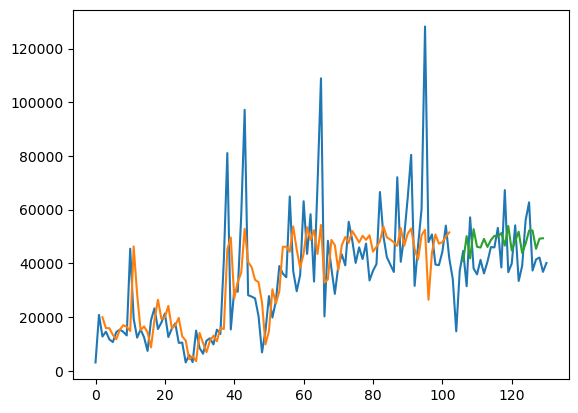

In [21]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [22]:
# proposed relevant datasets for dashboard??

# take customers of one cluster
print(c_subsets[2].head())
print("")
# calculate aggregated revenue of these customers per week
print(lstmdatainput.head())
print("")
# predict future revenue per week
print(testPredict)

     CustomerID  cluster
362    10255544        2
571    10403731        2
629    10446652        2
660    10465952        2
1748     150085        2

   OrderDate    NetRevenue
0 2021-12-27   3061.350785
1 2022-01-03  20784.907068
2 2022-01-10  12727.215969
3 2022-01-17  14527.650524
4 2022-01-24  11662.307592

[[40825.246]
 [50121.38 ]
 [41858.62 ]
 [52709.746]
 [46157.89 ]
 [45872.492]
 [49109.125]
 [46092.684]
 [48680.23 ]
 [50243.508]
 [49964.188]
 [51289.08 ]
 [46590.5  ]
 [53914.34 ]
 [44794.445]
 [48293.91 ]
 [51784.863]
 [43844.97 ]
 [47306.305]
 [52181.86 ]
 [52234.82 ]
 [45398.805]
 [49176.777]
 [49328.08 ]]
